# Evaluate BARPA-R for CAT turbulence indices.
Use a reanalysis such as BARRA-R or ERA5 for the "truth"

Evaluate:

    * pdf of values using quantiles and KS test
    * spatial distribution
    * time series


In [1]:
import xarray as xr
import glob
import intake
import numpy as np
import seaborn as sns
from scipy import stats
import pandas as pd
import calendar
import os

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

import logging
logging.getLogger("flox").setLevel(logging.WARNING)

In [2]:
from plotting_maps.acs_plotting_maps import plot_acs_hazard_multi, plot_acs_hazard, plot_data, cmap_dict, regions_dict
from matplotlib import colors, cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# from dask.diagnostics import ProgressBar
# # ProgressBar().register()

# import dask
# from dask.distributed import Client
# client = Client(threads_per_worker=2, n_workers=1)
# client

In [3]:
year = 2049
file = f"/scratch/v46/gt3409/TMP_windspeed/TMP_windspeed_AUS-15_ACCESS-CM2_ssp126_r4i1p1f1_BOM_BARPA-R_v1-r1_6hr_{year}.nc"
ds = xr.open_dataset(file)

In [4]:
ds["windspeed"].isnull().sum()

<xarray.DataArray 'windspeed' ()> Size: 8B
array(2710176)
Coordinates:
    pressure  int64 8B ...

In [3]:
mid_lat_slice = slice(-50,-25)
lon_slice = slice(90,195)
baseline_time_range = np.arange(1990,2009+1)
baseline_time_slice = slice("1990", "2009")

turbulence_index = "windspeed"
p95, p99, p999 = (62.835737276077246, 75.76162159729002, 88.1229062187195)

In [4]:
list_evaluation = ['evaluation_ERA5_r1i1p1f1', 
                   'evaluation_BARRA-R_r1i1p1f1']

list_historical = ['historical_ACCESS-CM2_r4i1p1f1', 
                   'historical_ACCESS-ESM1-5_r6i1p1f1',
                   'historical_CESM2_r11i1p1f1', 
                   'historical_CMCC-ESM2_r1i1p1f1',
                   'historical_EC-Earth3_r1i1p1f1',
                   'historical_MPI-ESM1-2-HR_r1i1p1f1',
                   'historical_NorESM2-MM_r1i1p1f1',
                  ]

In [5]:
frequency = "monthly"
filename = f"/scratch/v46/gt3409/turbulence_AUSCAT/windspeed-{frequency}_percentiles_midlatbox.nc"

if os.path.exists(filename):
    print(f"File '{filename}' already exists.")
    ds = xr.open_dataset(filename)
    ds.load()
else:
    run_filename_list = [f"/scratch/v46/gt3409/TMP_{turbulence_index}/TMP_{turbulence_index}-{frequency}-percentiles_AUS-15_{run}_BOM_BARPA-R_v1-r1_6hr.nc"
                                        for run in list_evaluation + list_historical]
    ds = xr.open_mfdataset(run_filename_list,
                                       concat_dim = "run",
                                       combine="nested",
                                       # chunks = {"run":1, 
                                       #           "time":-1, 
                                       #           # "lat":-1,
                                       #           "lon":111, 
                                       #           "quantile":-1},
                                       preprocess = lambda ds: ds.sel({"lat":mid_lat_slice, 
                                                                       "lon":lon_slice})\
                                                                 .astype("float32")\
                                                                 .mean(["lat", "lon"]),
                          )
    ds = ds.load()
    ds.to_netcdf(filename)

File '/scratch/v46/gt3409/turbulence_AUSCAT/windspeed-monthly_percentiles_midlatbox.nc' already exists.


In [6]:
ds

<xarray.Dataset> Size: 868kB
Dimensions:    (run: 9, time: 240, quantile: 100)
Coordinates:
    pressure   int64 8B 250
  * quantile   (quantile) float64 800B 0.0 0.01 0.02 0.03 ... 0.97 0.98 0.99
  * time       (time) datetime64[ns] 2kB 1990-01-31 1990-02-28 ... 2009-12-31
  * run        (run) <U24 864B 'evaluation_ERA5_r1i1p1f1' ... 'historical_Nor...
Data variables:
    windspeed  (run, time, quantile) float32 864kB 4.765 6.812 ... 49.22 51.08

In [60]:
ds.sel({"quantile":0.99})[turbulence_index]

<xarray.DataArray 'windspeed' (run: 9, time: 240)> Size: 9kB
array([[58.70036 , 49.407993, 54.562046, ..., 61.329365, 61.018726,
        57.919373],
       [60.262203, 50.284664, 58.813614, ..., 63.249157, 62.864048,
        60.15555 ],
       [51.986725, 52.063534, 58.937126, ..., 67.03469 , 65.02875 ,
        59.36314 ],
       ...,
       [57.356564, 51.155308, 51.34417 , ..., 65.59654 , 56.744957,
        56.38274 ],
       [57.78533 , 55.356773, 60.38604 , ..., 73.05183 , 62.541187,
        57.096657],
       [63.901123, 66.25601 , 58.216175, ..., 67.334015, 57.05841 ,
        51.08008 ]], dtype=float32)
Coordinates:
    pressure  int64 8B 250
    quantile  float64 8B 0.99
  * time      (time) datetime64[ns] 2kB 1990-01-31 1990-02-28 ... 2009-12-31
  * run       (run) <U24 864B 'evaluation_ERA5_r1i1p1f1' ... 'historical_NorE...

In [170]:
df = ds.sel({"quantile":0.99})[turbulence_index].resample(time="Y").std().to_dataframe().reset_index()
df

KeyError: "'quantile' is not a valid dimension or coordinate for Dataset with dimensions FrozenMappingWarningOnValuesAccess({'run': 24, 'time': 1464})"

<Axes: xlabel='windspeed', ylabel='Density'>

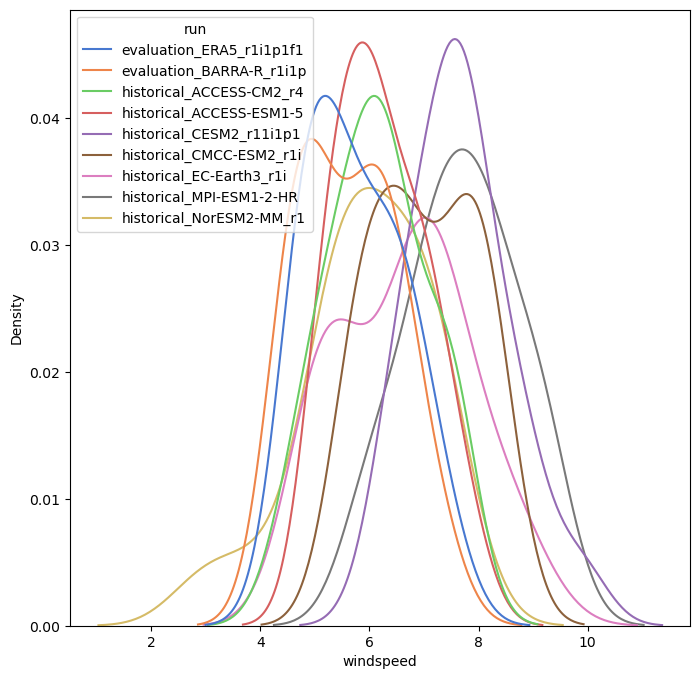

In [70]:
plt.figure(figsize=(8,8))
sns.kdeplot(data=df,  x="windspeed", hue="run", palette="muted",  )

<Axes: xlabel='time', ylabel='windspeed'>

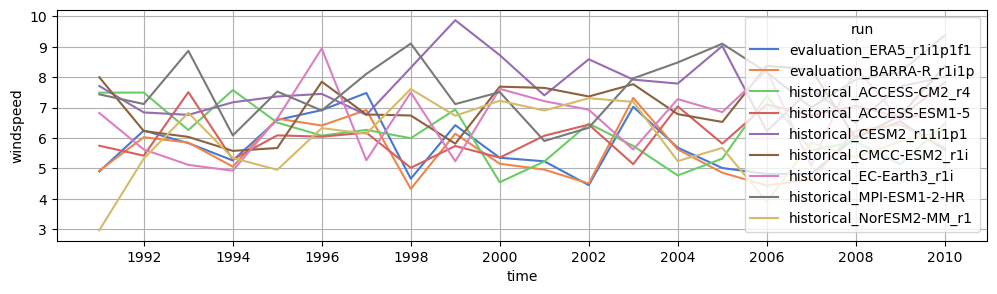

In [62]:
plt.figure(figsize=(12,3))
plt.grid()
sns.lineplot(data=df, x="time", y="windspeed", hue="run", palette="muted", )

In [57]:
for run in list_historical:
    print(xr.corr(ds.sel({"quantile":0.99,"run":'evaluation_BARRA-R_r1i1p'})[turbulence_index], 
                  ds.sel({"quantile":0.99,"run":run[:24]})[turbulence_index],
                 ).values)

0.6898573996712762
0.7438195471798561
0.7417440285437119
0.7675645602230646
0.7185345429307782
0.7329550104307975
0.6615707531188754


In [171]:
ds = xr.open_dataset("/g/data/v46/gt3409/turbulence_AUSCAT/windspeed-freq-above-p99_AUS-15_BOM_BARPA-R_v1-r1_6hr_monthly.nc")

In [181]:
df = ds.sel({"run":list_evaluation[1:] + list_historical, "time":slice("1990", "2009")})[turbulence_index].to_dataframe().reset_index()
df["experiment"] = [x.split("_")[0] for x in df["run"]]
df["month"] = df["time"].dt.month
df["year"] = df["time"].dt.year

(0.0, 0.2)

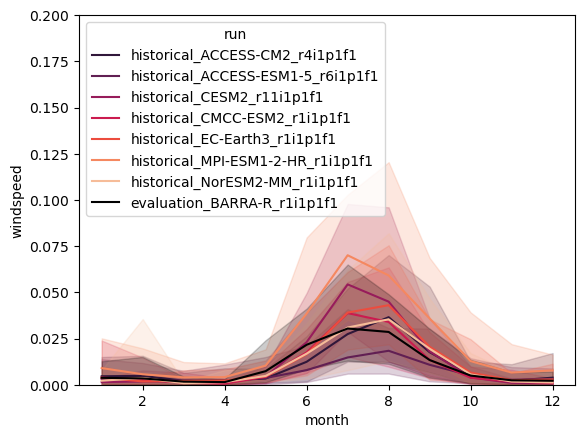

In [208]:
sns.lineplot(df[df["run"].isin(list_historical)], x="month", y="windspeed", hue="run", errorbar=('pi', 100), palette="rocket")
sns.lineplot(df[df["run"]==list_evaluation[1]], x="month", y="windspeed", hue="run", errorbar=('pi', 100), palette=["black"] )

plt.ylim((0,0.2))

(0.0, 0.1)

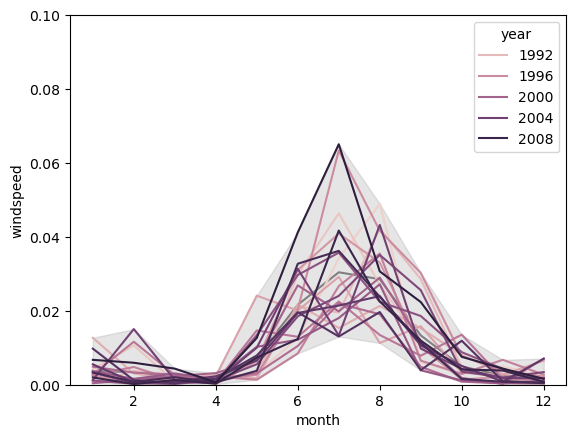

In [194]:
sns.lineplot(df[df["run"]==list_evaluation[1]], x="month", y="windspeed",  errorbar=('pi', 100), color="grey" )
sns.lineplot(df[df["run"]==list_evaluation[1]], x="month", y="windspeed", hue="year", errorbar=('pi', 100), )

plt.ylim((0,0.1))

In [185]:
df[df["run"]==list_evaluation[1]]

,run,time,pressure,windspeed,experiment,month,year
0,evaluation_BARRA-R_r1i1p1f1,1990-01-31,250,0.003811,evaluation,1,1990
1,evaluation_BARRA-R_r1i1p1f1,1990-02-28,250,0.000344,evaluation,2,1990
2,evaluation_BARRA-R_r1i1p1f1,1990-03-31,250,0.001441,evaluation,3,1990
3,evaluation_BARRA-R_r1i1p1f1,1990-04-30,250,0.001908,evaluation,4,1990
4,evaluation_BARRA-R_r1i1p1f1,1990-05-31,250,0.003208,evaluation,5,1990
...,...,...,...,...,...,...,...
235,evaluation_BARRA-R_r1i1p1f1,2009-08-31,250,0.030665,evaluation,8,2009
236,evaluation_BARRA-R_r1i1p1f1,2009-09-30,250,0.022373,evaluation,9,2009
237,evaluation_BARRA-R_r1i1p1f1,2009-10-31,250,0.007549,evaluation,10,2009
238,evaluation_BARRA-R_r1i1p1f1,2009-11-30,250,0.004358,evaluation,11,2009


(0.0, 0.15)

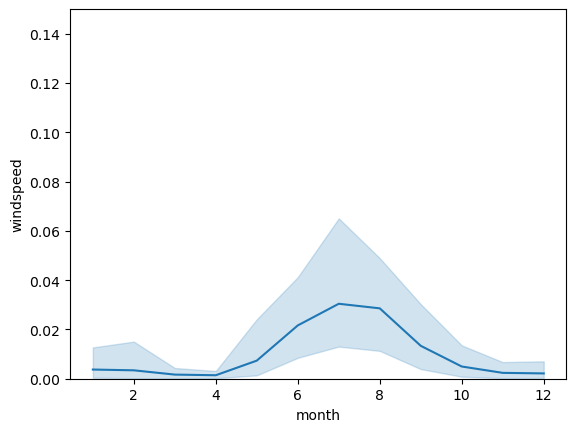

In [189]:
sns.lineplot(df[df["run"]==list_evaluation[1]], x="month", y="windspeed",  errorbar=('pi', 100), )

plt.ylim((0,0.15))

<Axes: xlabel='time', ylabel='windspeed'>

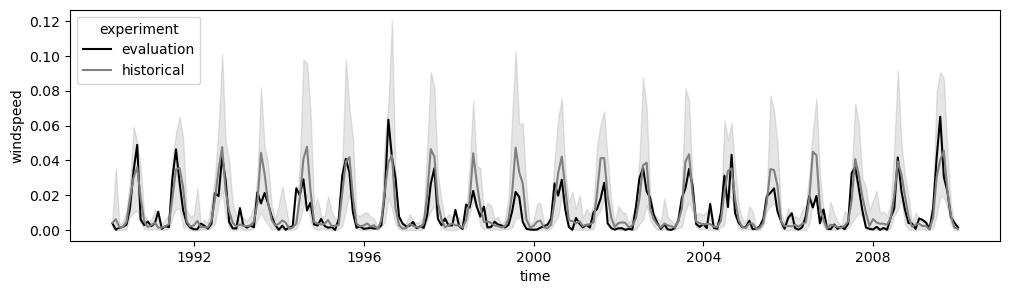

In [209]:
plt.figure(figsize=(12, 3))
sns.lineplot(df, x="time", y=turbulence_index, hue="experiment", errorbar=('pi', 100), palette=["k", "grey"],)

(0.0, 0.22)

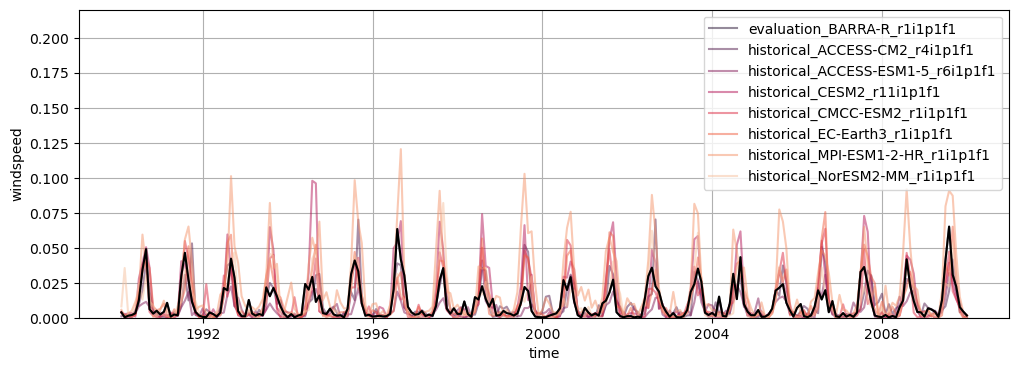

In [197]:
plt.figure(figsize=(12, 4))
plt.grid()
sns.lineplot(df, x="time", y=turbulence_index, hue="run", errorbar=('pi', 100), palette="rocket", alpha=0.5)
sns.lineplot(df[df["run"]==list_evaluation[1]], x="time", y=turbulence_index, errorbar=('pi', 100), color="k",)
plt.ylim((0,0.22))
# plt.legend("")

# Kovmogolov-Smirnov two sample test for model evaluation

In [6]:
def plot_kstest(ds_eval, ds_hist, turbulence_index, time_selection, evaluation, run, pvalue, significance, ax=None, show_years=False):
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_title(f"{run} in {time_selection}")        

    if show_years:
        # show each single year
        for year in np.arange(1990,2009):
            sns.lineplot(data = ds_eval.sel({"time": (ds_eval.time.dt.year==year)}).mean("time"),
                         x="windspeed",
                         y="quantile",
                         color="r",
                         alpha=0.1,
                         ax=ax)
        for year in np.arange(1990,2009):
            sns.lineplot(data = ds_hist.sel({"time": (ds_hist.time.dt.year==year)}).mean("time"),
                         x="windspeed",
                         y="quantile",
                         color="k",
                         alpha=0.1,
                         ax=ax)
            
    # empirical CDF for ks test        
    sns.ecdfplot(data = ds_eval.mean("time")["windspeed"], color="k", label=evaluation, ax=ax,)
    sns.ecdfplot(data = ds_hist.mean("time")["windspeed"], color="r", label=run, ax=ax,)
    
    # add pvalue to plot
    ax.text(x=0.98, y=0.02, s= f"pvalue = {pvalue:.3f}{significance}", transform = ax.transAxes, va="bottom", ha="right",)
    ax.set_xlabel(turbulence_index)
    ax.legend(loc="upper left", fontsize=10)
    # plt.close()
    return 


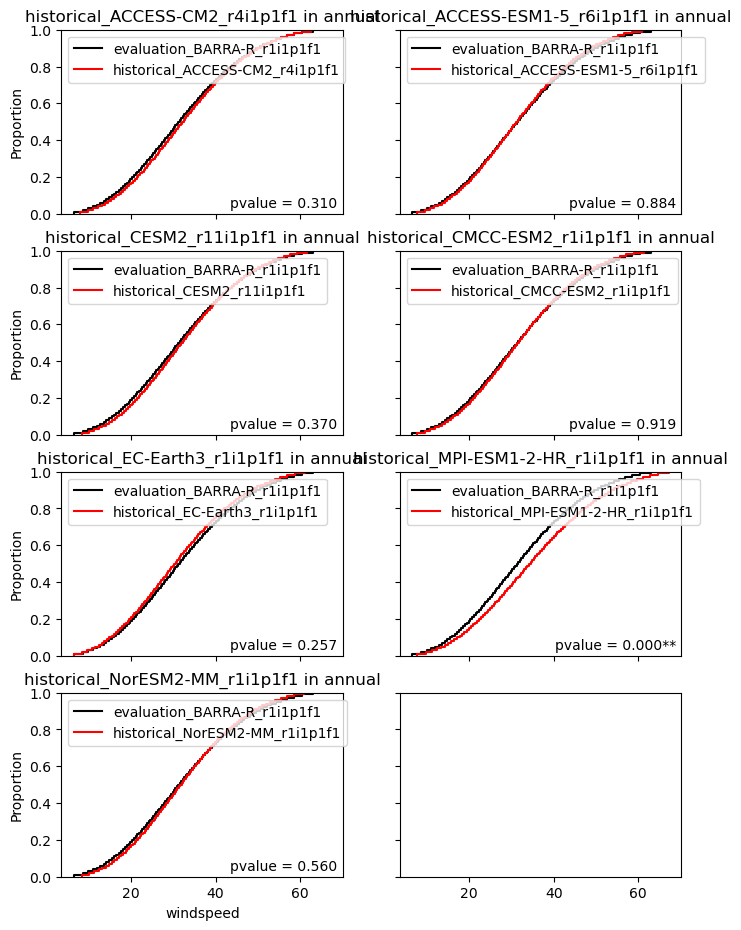

In [7]:
time_selection="annual"
nrows = 4
ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols,
                         figsize=(8,11),
                         sharex=True, sharey=True)

# fig.suptitle(f"Model evaluation KS test for {time_selection}")
evaluation = list_evaluation[1]
for i, run in enumerate(list_historical):
    # annual
    ds_eval = ds.sel({"run":evaluation[:24]})
    ds_hist = ds.sel({"run":run[:24]})

    # calculate pvalue
    ks_statistic, pvalue = stats.ks_2samp(ds_eval.resample({"time":"YE"}).mean()["windspeed"].values.flatten(),
                                          ds_hist.resample({"time":"YE"}).mean()["windspeed"].values.flatten(),)
    
    if pvalue < 0.01:
        significance = "**"
    elif pvalue < 0.05:
        significance = "*"
    else:
        significance = ""

    plot_kstest(ds_eval, ds_hist, turbulence_index, time_selection, evaluation, run, pvalue, significance, ax=axes[i//ncols, i%ncols])

fig.savefig(f"/home/563/gt3409/turbulence_AUSCAT/evaluation_kstest_plots_{time_selection}.png")


In [8]:
def plot_kde_ttest(ds_eval, ds_hist, turbulence_index, time_selection, evaluation, run, pvalue, significance, ax=None, show_years=False):
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_title(f"{run} in {time_selection}")        

    if show_years:
        # show each single year
        for year in np.arange(1990,2009):
            sns.lineplot(data = ds_eval.sel({"time": (ds_eval.time.dt.year==year)}).mean("time"),
                         x=turbulence_index,
                         y="quantile",
                         color="r",
                         alpha=0.1,
                         ax=ax)
        for year in np.arange(1990,2009):
            sns.lineplot(data = ds_hist.sel({"time": (ds_hist.time.dt.year==year)}).mean("time"),
                         x=turbulence_index,
                         y="quantile",
                         color="k",
                         alpha=0.1,
                         ax=ax)
            
    # empirical CDF for ks test        
    sns.kdeplot(data = ds_eval[turbulence_index], color="k", label=evaluation, ax=ax,)
    sns.kdeplot(data = ds_hist[turbulence_index], color="r", label=run, ax=ax,)
    
    # add pvalue to plot
    ax.text(x=0.98, y=0.02, s= f"pvalue = {pvalue:.3f}{significance}", transform = ax.transAxes, va="bottom", ha="right",)
    ax.set_xlabel(turbulence_index)
    ax.legend(loc="upper left", fontsize=10)
    # plt.close()
    return 


In [9]:
kstest_table = [["sample1", "sample2", "time_selection", "mon/seas/yr", "pvalue", "significance"]]

evaluation = list_evaluation[1]

for run in list_historical:
    # annual
    ds_eval = ds.sel({"run":evaluation[:24]})
    ds_hist = ds.sel({"run":run[:24]})

    # calculate pvalue
    ks_statistic, pvalue = stats.ks_2samp(ds_eval.resample({"time":"YE"}).mean()["windspeed"].values.flatten(),
                                          ds_hist.resample({"time":"YE"}).mean()["windspeed"].values.flatten(),)
    
    if pvalue < 0.01:
        significance = "**"
    elif pvalue < 0.05:
        significance = "*"
    else:
        significance = ""

    # update ks test stats
    kstest_table.append([evaluation, run, "annual", "year", f"{pvalue:.3f}", significance])

    if False:
        plot_kstest(ds_eval, ds_hist, time_selection, evaluation, run, pvalue)

    # seasonal
    for time_selection in ["DJF", "MAM", "JJA", "SON"]:
        ds_hist = ds.sel({"run":run[:24], "time": (ds.time.dt.season==time_selection)}).resample({"time":"QS-DEC"}).mean()
        ds_eval = ds.sel({"run":evaluation[:24], "time": (ds.time.dt.season==time_selection)}).resample({"time":"QS-DEC"}).mean()

        # calculate pvalue
        ks_statistic, pvalue = stats.ks_2samp(ds_eval.resample({"time":"YE"}).mean()["windspeed"].values.flatten(),
                                              ds_hist.resample({"time":"YE"}).mean()["windspeed"].values.flatten(),)
        
        if pvalue < 0.01:
            significance = "**"
        elif pvalue < 0.05:
            significance = "*"
        else:
            significance = ""

        # update ks test stats
        kstest_table.append([evaluation, run, time_selection, "season", f"{pvalue:.3f}", significance])

        if False:
            plot_kstest(ds_eval, ds_hist, time_selection, evaluation, run, pvalue)

    # monthly
    for time_selection in np.arange(1,12+1):
        ds_hist = ds.sel({"run":run[:24], "time": (ds.time.dt.month==time_selection)})
        ds_eval = ds.sel({"run":evaluation[:24], "time": (ds.time.dt.month==time_selection)})

        # calculate pvalue
        ks_statistic, pvalue = stats.ks_2samp(ds_eval.resample({"time":"YE"}).mean()["windspeed"].values.flatten(),
                                              ds_hist.resample({"time":"YE"}).mean()["windspeed"].values.flatten(),)
        # print(f"{run}: pvalue {pvalue:.3f}, ks_stat = {ks_statistic}")
        
        if pvalue < 0.01:
            significance = "**"
        elif pvalue < 0.05:
            significance = "*"
        else:
            significance = ""

        kstest_table.append([evaluation, run, calendar.month_name[time_selection], "month", f"{pvalue:.3f}", significance])     

        if False:
            plot_kstest(ds_eval, ds_hist, time_selection, evaluation, run, pvalue)

kstest_df = pd.DataFrame(columns = kstest_table[0], data = kstest_table[1:])
kstest_df.to_csv("/home/563/gt3409/turbulence_AUSCAT/evaluation_kstest_table.csv")
kstest_df

,sample1,sample2,time_selection,mon/seas/yr,pvalue,significance
0,evaluation_BARRA-R_r1i1p1f1,historical_ACCESS-CM2_r4i1p1f1,annual,year,0.310,
1,evaluation_BARRA-R_r1i1p1f1,historical_ACCESS-CM2_r4i1p1f1,DJF,season,0.999,
2,evaluation_BARRA-R_r1i1p1f1,historical_ACCESS-CM2_r4i1p1f1,MAM,season,0.150,
3,evaluation_BARRA-R_r1i1p1f1,historical_ACCESS-CM2_r4i1p1f1,JJA,season,0.082,
4,evaluation_BARRA-R_r1i1p1f1,historical_ACCESS-CM2_r4i1p1f1,SON,season,0.212,
...,...,...,...,...,...,...
114,evaluation_BARRA-R_r1i1p1f1,historical_NorESM2-MM_r1i1p1f1,August,month,0.018,*
115,evaluation_BARRA-R_r1i1p1f1,historical_NorESM2-MM_r1i1p1f1,September,month,0.001,**
116,evaluation_BARRA-R_r1i1p1f1,historical_NorESM2-MM_r1i1p1f1,October,month,0.198,
117,evaluation_BARRA-R_r1i1p1f1,historical_NorESM2-MM_r1i1p1f1,November,month,0.948,


# Spatial evaluation

In [10]:
ds = xr.open_dataset("/scratch/v46/gt3409/turbulence_AUSCAT/windspeed-ann-freq-above-p99_mapped.nc")
ds = ds.sel({"time":baseline_time_slice, "lon":lon_slice, })
ds

<xarray.Dataset> Size: 569MB
Dimensions:    (run: 24, time: 20, lat: 436, lon: 680)
Coordinates:
  * lon        (lon) float64 5kB 90.04 90.2 90.35 90.51 ... 194.6 194.8 194.9
  * lat        (lat) float64 3kB -53.58 -53.42 -53.27 ... 13.32 13.48 13.63
  * time       (time) datetime64[ns] 160B 1990-12-31 1991-12-31 ... 2009-12-31
    pressure   int64 8B ...
  * run        (run) <U27 3kB 'evaluation_BARRA-R_r1i1p1f1' ... 'ssp585_EC-Ea...
Data variables:
    windspeed  (run, time, lat, lon) float32 569MB ...
Attributes:
    regrid_method:  bilinear

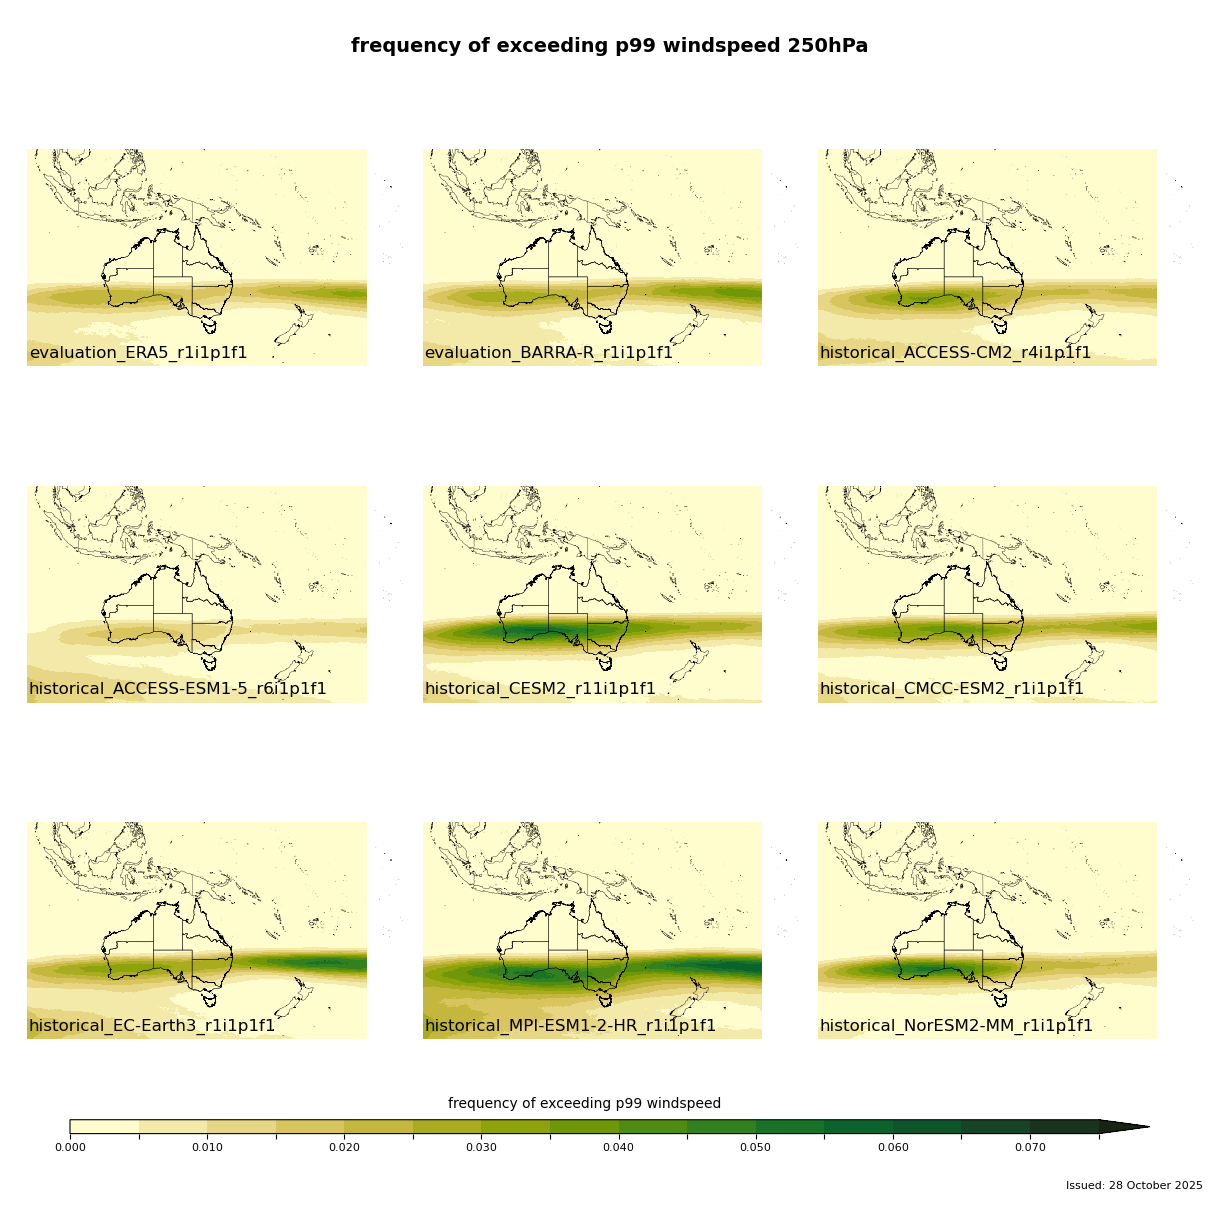

In [11]:
fig, axs = plot_acs_hazard_multi(nrows=3, 
                      ncols=3, 
                      ds_list=[ds.sel(run=run[:27])[f"{turbulence_index}"].mean("time")
                               for run in list_evaluation+ list_historical],
                      mask_not_australia=False,
                      ticks=np.arange(0, 0.08, 0.005),
                      tick_interval=2,
                      cbar_extend="max",
                      cbar_label=f"frequency of exceeding p99 {turbulence_index}",
                      figsize=(12,12),
                      title=f"frequency of exceeding p99 {turbulence_index} 250hPa",
                      subplot_titles=[run for run in list_evaluation+ list_historical],
                      xlim=(88.04 , 207.9),
                      ylim=(-53.58 , 13.63),
                      coastlines=True,
                      projection=ccrs.PlateCarree(130),
                      cmap=cmap_dict["ipcc_wind_seq"],
                      watermark="",
                      show_copyright=False,
                     );

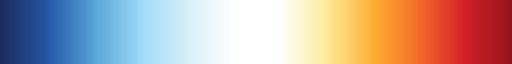

In [12]:
cmap_dict["anom"].set_bad("grey")
cmap_dict["anom"]

In [13]:
baseline = ds.sel(run='evaluation_BARRA-R_r1i1p1f1'[:27], time=baseline_time_slice)[turbulence_index].mean("time")
baseline.compute()

<xarray.DataArray 'windspeed' (lat: 436, lon: 680)> Size: 1MB
array([[0.01105378, 0.0109852 , 0.01088264, ..., 0.00229359, 0.00225934,
        0.00232774],
       [0.011122  , 0.01125889, 0.0110536 , ..., 0.00219085, 0.002225  ,
        0.00212226],
       [0.01129323, 0.01139606, 0.01129332, ..., 0.00219085, 0.00219085,
        0.00212235],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)
Coordinates:
  * lon       (lon) float64 5kB 90.04 90.2 90.35 90.51 ... 194.6 194.8 194.9
  * lat       (lat) float64 3kB -53.58 -53.42 -53.27 ... 13.32 13.48 13.63
    pressure  int64 8B 250
    run       <U27 108B 'evaluation_BARRA-R_r1i1p1f1'

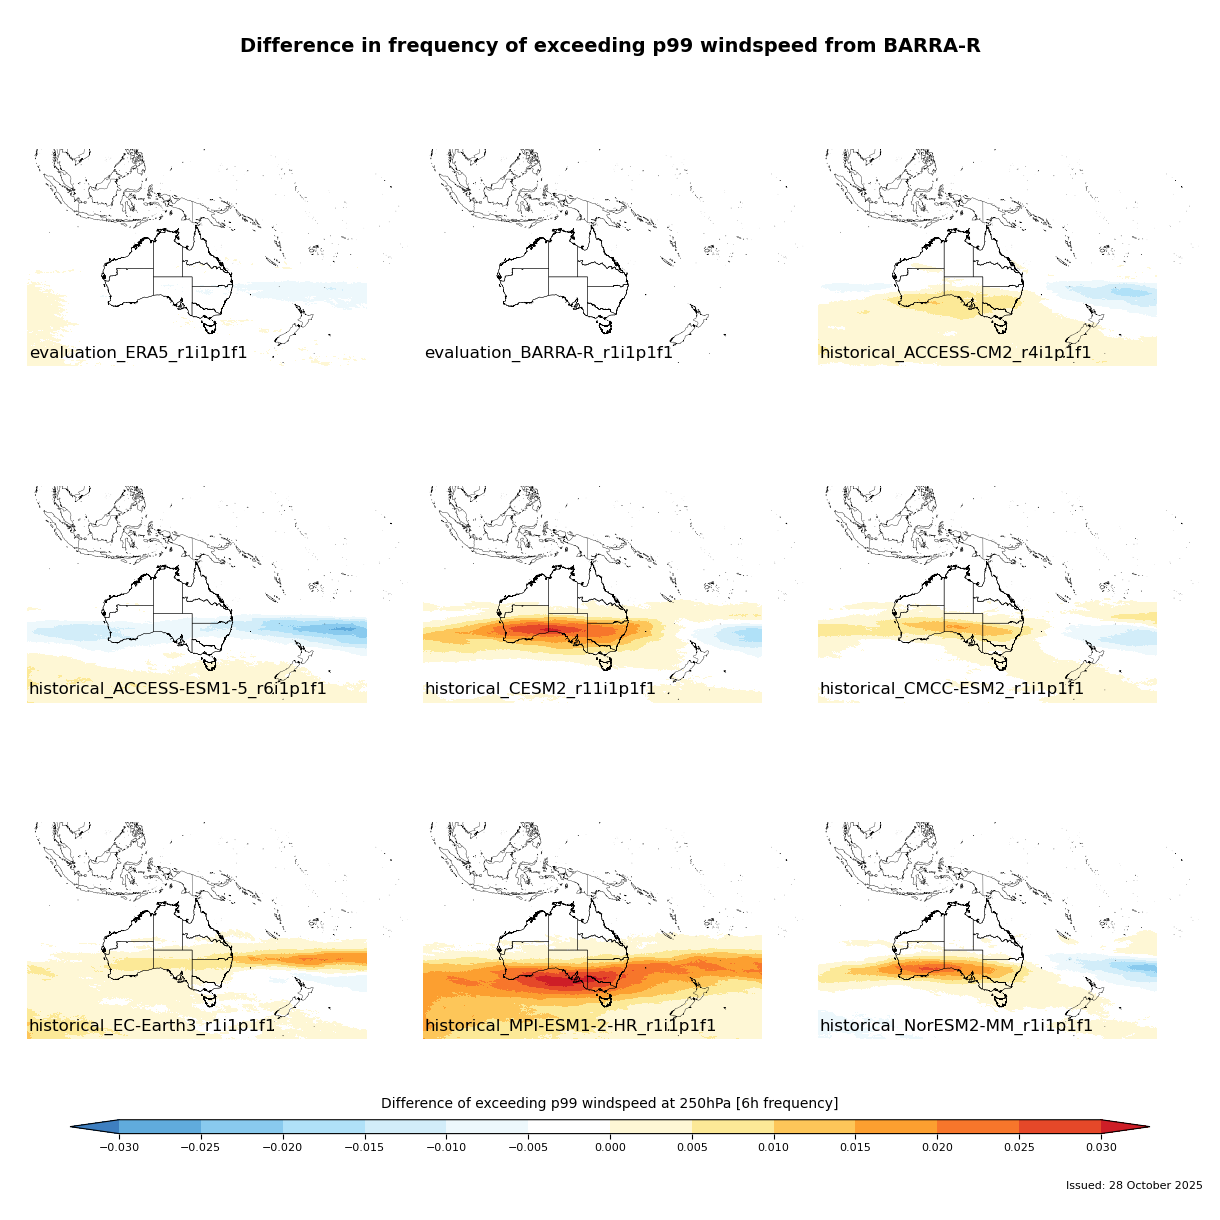

In [14]:
plot_acs_hazard_multi(nrows=3, 
                      ncols=3, 
                      ds_list=[ds.sel(run=run[:27])[turbulence_index].mean("time")-baseline 
                               for run in list_evaluation+ list_historical],
                      mask_not_australia=False,
                      ticks=np.arange(-0.03, 0.031, 0.005),
                      vcentre=0,
                      # ticks=[1/5, 1/4, 1/3, 1/2, 2/3, 1, 3/2, 2, 3, 4, 5],
                      # vcentre=1,
                      tick_interval=1,
                      cbar_extend="both",
                      title=f"Difference in frequency of exceeding p99 {turbulence_index} from BARRA-R",
                      figsize=(12,12),
                      cbar_label=f"Difference of exceeding p99 {turbulence_index} at 250hPa [6h frequency]",
                      subplot_titles=[run for run in list_evaluation+ list_historical],
                      xlim=(88.04 , 207.9),
                      ylim=(-53.58 , 13.63),
                      coastlines=True,
                      projection=ccrs.PlateCarree(130),
                      # cmap=cmap_dict["ipcc_wind_div"],
                      cmap=cmap_dict["anom"],
                      watermark="",
                      show_copyright=False,
                     );

In [15]:
# ttest
pval_list = []
for run in list_evaluation + list_historical:
    # for one historical run
    ds_eval = ds.sel({"run":list_evaluation[1][:27], })
    ds_hist = ds.sel({"run":run[:27], })
    stat, pval = stats.ttest_ind(ds_eval[turbulence_index], ds_hist[turbulence_index])
    pval_list.append(xr.Dataset(data_vars={"pval" : (["lat", "lon"],  pval),}, 
                                coords= {"lat": ds_hist.lat, "lon": ds_hist.lon},))
pvals = xr.concat(pval_list,dim="run")
pvals

<xarray.Dataset> Size: 21MB
Dimensions:   (run: 9, lat: 436, lon: 680)
Coordinates:
  * lat       (lat) float64 3kB -53.58 -53.42 -53.27 ... 13.32 13.48 13.63
    pressure  int64 8B 250
  * run       (run) <U27 972B 'evaluation_ERA5_r1i1p1f1' ... 'historical_NorE...
  * lon       (lon) float64 5kB 90.04 90.2 90.35 90.51 ... 194.6 194.8 194.9
Data variables:
    pval      (run, lat, lon) float64 21MB 0.07466 0.07147 0.06448 ... nan nan

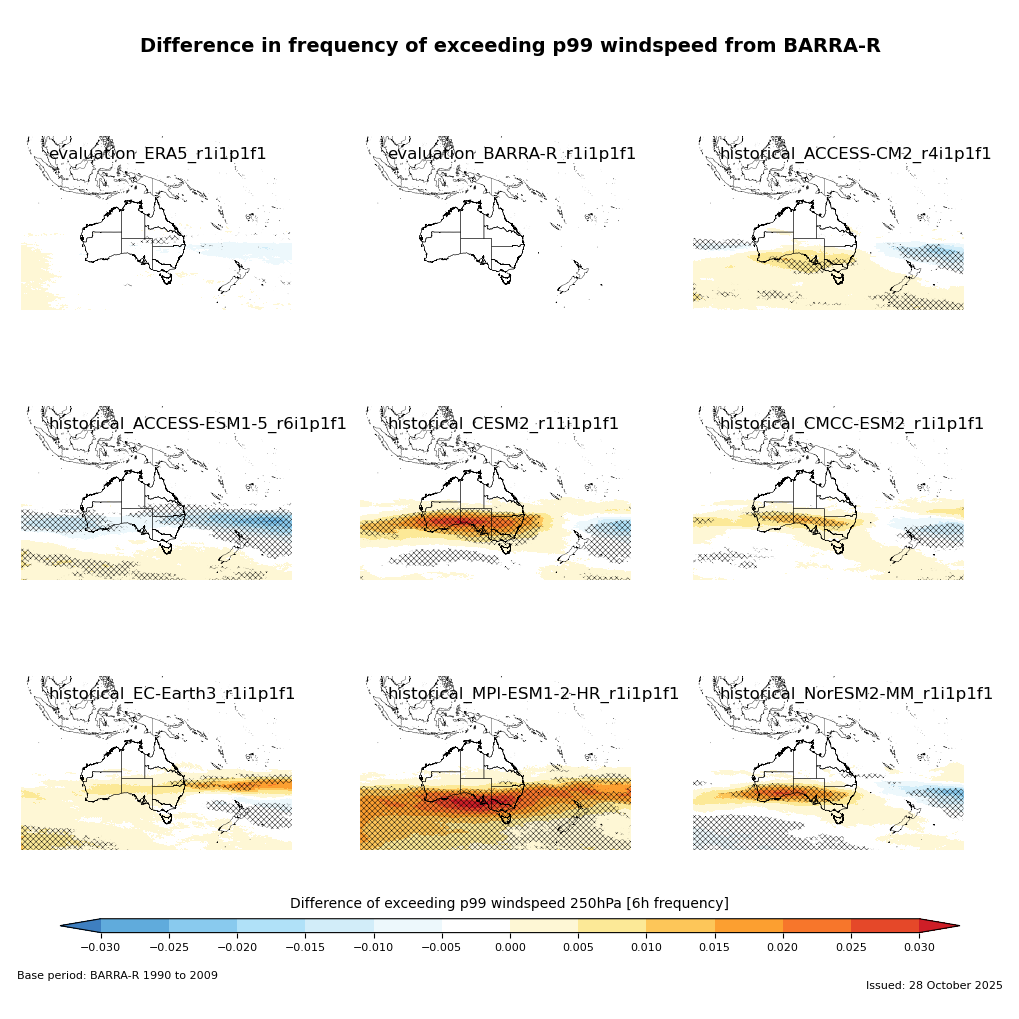

In [26]:
# ttest
pval_list = []
for run in list_evaluation + list_historical:
    # for one historical run
    ds_eval = ds.sel({"run":list_evaluation[1][:27], })
    ds_hist = ds.sel({"run":run[:27], })
    stat, pval = stats.ttest_ind(ds_eval[turbulence_index], ds_hist[turbulence_index])
    pval_list.append(xr.Dataset(data_vars={"pval" : (["lat", "lon"],  pval),}, 
                                coords= {"lat": ds_hist.lat, "lon": ds_hist.lon},))
pvals = xr.concat(pval_list,dim="run")
pvals_stippling=[pvals.sel(run=run[:27])["pval"] <0.01
                                      for run in list_evaluation+ list_historical]
plot_acs_hazard_multi(nrows=3, 
                      ncols=3, 
                      ds_list=[ds.sel(run=run[:27])[turbulence_index].mean("time")-baseline 
                               for run in list_evaluation+ list_historical],
                      stippling_list=pvals_stippling,
                      mask_not_australia=False,
                      # ticks=[1/5, 1/4, 1/3, 1/2, 2/3, 1, 3/2, 2, 3, 4, 5],
                      ticks=np.arange(-0.03, 0.031, 0.005),
                      vcentre=0,
                      tick_interval=1,
                      cbar_extend="both",
                      title=f"Difference in frequency of exceeding p99 {turbulence_index} from BARRA-R",
                      baseline= "BARRA-R 1990 to 2009",
                      figsize=(10,10),
                      cbar_label=f"Difference of exceeding p99 {turbulence_index} 250hPa [6h frequency]",
                      subplot_titles=[run for run in list_evaluation+ list_historical],
                      subtitle_xy=(0.1, 0.85),
                      xlim=(90 , 195),
                      ylim=(-53.58 , 13.63),
                      coastlines=True,
                      projection=ccrs.PlateCarree(130),
                      # cmap=cmap_dict["ipcc_wind_div"],
                      cmap=cmap_dict["anom"],
                      watermark="",
                      show_copyright=False,
                     );

In [19]:
ds = xr.open_mfdataset([f"/scratch/v46/gt3409/TMP_windspeed-freq-above-p99/TMP_windspeed-monthly-freq-above-p99_{run}.nc" for run in list_evaluation+list_historical],
                      concat_dim="run",
                      combine="nested",)
ds = ds.sel({"time":baseline_time_slice, "lon":lon_slice })
ds

<xarray.Dataset> Size: 3GB
Dimensions:    (run: 9, time: 240, lat: 436, lon: 680)
Coordinates:
  * lon        (lon) float64 5kB 90.04 90.2 90.35 90.51 ... 194.6 194.8 194.9
  * lat        (lat) float64 3kB -53.58 -53.42 -53.27 ... 13.32 13.48 13.63
  * time       (time) datetime64[ns] 2kB 1990-01-31 1990-02-28 ... 2009-12-31
    pressure   int64 8B 250
  * run        (run) <U33 1kB 'evaluation_ERA5_r1i1p1f1' ... 'historical_NorE...
Data variables:
    windspeed  (run, time, lat, lon) float32 3GB dask.array<chunksize=(1, 240, 436, 680), meta=np.ndarray>
Attributes:
    long_name:      Air Temperature
    standard_name:  air_temperature
    units:          K
    cell_methods:   pressure: point time: point (interval: 6H) area: interpol...
    grid_mapping:   crs

In [46]:
ds = xr.open_mfdataset([f"/scratch/v46/gt3409/TMP_windspeed-freq-above-p99/TMP_windspeed-monthly-freq-above-p99_{run}.nc" for run in list_evaluation+list_historical],
                      concat_dim="run",
                      combine="nested",)
ds = ds.sel({"time":baseline_time_slice, "lon":lon_slice })
ds=ds.load()

# median ttest value in the mid lat box to evaluation spatial conherence
ttest_table = [["sample1", "sample2", "time_selection", "mon/seas/yr", "median_pvalue", "significance"]]

evaluation = list_evaluation[1]

for run in list_historical:
    # annual
    ds_eval = ds.sel({"run":evaluation})
    ds_hist = ds.sel({"run":run})

    # calculate pvalue
    stat, pvalue = stats.ttest_ind(ds_eval.resample({"time":"YE"}).mean()[turbulence_index],
                                   ds_hist.resample({"time":"YE"}).mean()[turbulence_index])

    pvalue = xr.Dataset(data_vars={"pval" : (["lat", "lon"],  pvalue),}, 
                        coords= {"lat": ds_hist.lat, "lon": ds_hist.lon},
                       )["pval"].median(["lat", "lon"])
    
    # mark significance
    if pvalue < 0.01:
        significance = "**"
    elif pvalue < 0.05:
        significance = "*"
    else:
        significance = ""

    # update t test stats
    ttest_table.append([evaluation, run, "annual", "year", f"{pvalue:.3f}", significance])

    if False:
        plot_kde_test(ds_eval, ds_hist, time_selection, evaluation, run, pvalue)
    
    # seasonal
    ds_hist_seas = ds.sel({"run":run,}).resample({"time":"QS-DEC"}).mean().sel({"time":baseline_time_slice})
    ds_eval_seas = ds.sel({"run":evaluation,}).resample({"time":"QS-DEC"}).mean().sel({"time":baseline_time_slice})
    
    for time_selection in ["DJF", "MAM", "JJA", "SON"]:
        ds_hist = ds_hist_seas.sel({"time": (ds_hist_seas.time.dt.season==time_selection)})
        ds_eval = ds_eval_seas.sel({"time": (ds_eval_seas.time.dt.season==time_selection)})

        # calculate pvalue
        stat, pvalue = stats.ttest_ind(ds_eval.resample({"time":"YE"}).mean()[turbulence_index],
                                   ds_hist.resample({"time":"YE"}).mean()[turbulence_index])

        pvalue = xr.Dataset(data_vars={"pval" : (["lat", "lon"],  pvalue),}, 
                        coords= {"lat": ds_hist.lat, "lon": ds_hist.lon},
                       )["pval"].median(["lat", "lon"])
        
        if pvalue < 0.01:
            significance = "**"
        elif pvalue < 0.05:
            significance = "*"
        else:
            significance = ""

        # update t test stats
        ttest_table.append([evaluation, run, time_selection, "season", f"{pvalue:.3f}", significance])

        if False:
            plot_kde_ttest(ds_eval, ds_hist, time_selection, evaluation, run, pvalue)

    # monthly
    for time_selection in np.arange(1,12+1):
        ds_hist = ds.sel({"run":run, "time": (ds.time.dt.month==time_selection)})
        ds_eval = ds.sel({"run":evaluation, "time": (ds.time.dt.month==time_selection)})

        # calculate pvalue
        stat, pvalue = stats.ttest_ind(ds_eval.resample({"time":"YE"}).mean()[turbulence_index],
                                   ds_hist.resample({"time":"YE"}).mean()[turbulence_index])

        pvalue = xr.Dataset(data_vars={"pval" : (["lat", "lon"],  pvalue),}, 
                        coords= {"lat": ds_hist.lat, "lon": ds_hist.lon},
                       )["pval"].median(["lat", "lon"])
        
        
        if pvalue < 0.01:
            significance = "**"
        elif pvalue < 0.05:
            significance = "*"
        else:
            significance = ""

        ttest_table.append([evaluation, run, calendar.month_name[time_selection], "month", f"{pvalue:.3f}", significance])     

        if False:
            plot_kde_ttest(ds_eval, ds_hist, time_selection, evaluation, run, pvalue)

ttest_df = pd.DataFrame(columns = ttest_table[0], data = ttest_table[1:])
ttest_df.to_csv("/home/563/gt3409/turbulence_AUSCAT/evaluation_ttest_table.csv")
ttest_df

SyntaxError: 'break' outside loop (3636179680.py, line 6)

In [29]:
ds = xr.open_mfdataset([f"/scratch/v46/gt3409/TMP_windspeed-freq-above-p99/TMP_windspeed-monthly-freq-above-p99_{run}.nc" for run in list_evaluation+list_historical],
                      concat_dim="run",
                      combine="nested",)
ds = ds.sel({"time":baseline_time_slice, "lon":lon_slice })
ds=ds.load()

q=0.2

# q ttest value in the mid lat box to evaluation spatial conherence
ttest_table = [["sample1", "sample2", "time_selection", "mon/seas/yr", f"p{int(q*100)}_pvalue", "significance"]]

evaluation = list_evaluation[1]

for run in list_historical:
    # annual
    ds_eval = ds.sel({"run":evaluation})
    ds_hist = ds.sel({"run":run})

    # calculate pvalue
    stat, pvalue = stats.ttest_ind(ds_eval.resample({"time":"YE"}).mean()[turbulence_index],
                                   ds_hist.resample({"time":"YE"}).mean()[turbulence_index])

    pvalue = xr.Dataset(data_vars={"pval" : (["lat", "lon"],  pvalue),}, 
                        coords= {"lat": ds_hist.lat, "lon": ds_hist.lon},
                       )["pval"].quantile(q, dim=["lat", "lon"])
    
    # mark significance
    if pvalue < 0.01:
        significance = "**"
    elif pvalue < 0.05:
        significance = "*"
    else:
        significance = ""

    # update t test stats
    ttest_table.append([evaluation, run, "annual", "year", f"{pvalue:.3f}", significance])

    if False:
        plot_kde_test(ds_eval, ds_hist, time_selection, evaluation, run, pvalue)
    
    # seasonal
    ds_hist_seas = ds.sel({"run":run,}).resample({"time":"QS-DEC"}).mean().sel({"time":baseline_time_slice})
    ds_eval_seas = ds.sel({"run":evaluation,}).resample({"time":"QS-DEC"}).mean().sel({"time":baseline_time_slice})
    
    for time_selection in ["DJF", "MAM", "JJA", "SON"]:
        ds_hist = ds_hist_seas.sel({"time": (ds_hist_seas.time.dt.season==time_selection)})
        ds_eval = ds_eval_seas.sel({"time": (ds_eval_seas.time.dt.season==time_selection)})

        # calculate pvalue
        stat, pvalue = stats.ttest_ind(ds_eval.resample({"time":"YE"}).mean()[turbulence_index],
                                   ds_hist.resample({"time":"YE"}).mean()[turbulence_index])

        pvalue = xr.Dataset(data_vars={"pval" : (["lat", "lon"],  pvalue),}, 
                        coords= {"lat": ds_hist.lat, "lon": ds_hist.lon},
                       )["pval"].quantile(q, dim=["lat", "lon"])
        
        if pvalue < 0.01:
            significance = "**"
        elif pvalue < 0.05:
            significance = "*"
        else:
            significance = ""

        # update t test stats
        ttest_table.append([evaluation, run, time_selection, "season", f"{pvalue:.3f}", significance])

        if False:
            plot_kde_ttest(ds_eval, ds_hist, time_selection, evaluation, run, pvalue)

    # monthly
    for time_selection in np.arange(1,12+1):
        ds_hist = ds.sel({"run":run, "time": (ds.time.dt.month==time_selection)})
        ds_eval = ds.sel({"run":evaluation, "time": (ds.time.dt.month==time_selection)})

        # calculate pvalue
        stat, pvalue = stats.ttest_ind(ds_eval.resample({"time":"YE"}).mean()[turbulence_index],
                                   ds_hist.resample({"time":"YE"}).mean()[turbulence_index])

        pvalue = xr.Dataset(data_vars={"pval" : (["lat", "lon"],  pvalue),}, 
                        coords= {"lat": ds_hist.lat, "lon": ds_hist.lon},
                       )["pval"].quantile(q, dim=["lat", "lon"])
        
        
        if pvalue < 0.01:
            significance = "**"
        elif pvalue < 0.05:
            significance = "*"
        else:
            significance = ""

        ttest_table.append([evaluation, run, calendar.month_name[time_selection], "month", f"{pvalue:.3f}", significance])     

        if False:
            plot_kde_ttest(ds_eval, ds_hist, time_selection, evaluation, run, pvalue)

    

ttest_df = pd.DataFrame(columns = ttest_table[0], data = ttest_table[1:])
ttest_df.to_csv(f"/home/563/gt3409/turbulence_AUSCAT/evaluation_ttest_p{int(q*100)}_table.csv")
ttest_df

,sample1,sample2,time_selection,mon/seas/yr,p20_pvalue,significance
0,evaluation_BARRA-R_r1i1p1f1,historical_ACCESS-CM2_r4i1p1f1,annual,year,0.014,*
1,evaluation_BARRA-R_r1i1p1f1,historical_ACCESS-CM2_r4i1p1f1,DJF,season,0.141,
2,evaluation_BARRA-R_r1i1p1f1,historical_ACCESS-CM2_r4i1p1f1,MAM,season,0.065,
3,evaluation_BARRA-R_r1i1p1f1,historical_ACCESS-CM2_r4i1p1f1,JJA,season,0.065,
4,evaluation_BARRA-R_r1i1p1f1,historical_ACCESS-CM2_r4i1p1f1,SON,season,0.046,*
...,...,...,...,...,...,...
114,evaluation_BARRA-R_r1i1p1f1,historical_NorESM2-MM_r1i1p1f1,August,month,0.092,
115,evaluation_BARRA-R_r1i1p1f1,historical_NorESM2-MM_r1i1p1f1,September,month,0.073,
116,evaluation_BARRA-R_r1i1p1f1,historical_NorESM2-MM_r1i1p1f1,October,month,0.122,
117,evaluation_BARRA-R_r1i1p1f1,historical_NorESM2-MM_r1i1p1f1,November,month,0.107,


In [42]:
ds = xr.open_mfdataset([f"/scratch/v46/gt3409/TMP_windspeed-freq-above-p99/TMP_windspeed-monthly-freq-above-p99_{run}.nc" for run in list_evaluation+list_historical],
                      concat_dim="run",
                      combine="nested",)
ds = ds.sel({"time":baseline_time_slice, "lon":lon_slice })
ds=ds.load()

q=0.33

# q ttest value in the mid lat box to evaluation spatial conherence
ttest_table = [["sample1", "sample2", "time_selection", "mon/seas/yr", f"p{int(q*100)}_pvalue", "significance"]]

evaluation = list_evaluation[1]

for run in list_historical:
    # annual
    ds_eval = ds.sel({"run":evaluation})
    ds_hist = ds.sel({"run":run})

    # calculate pvalue
    stat, pvalue = stats.ttest_ind(ds_eval.resample({"time":"YE"}).mean()[turbulence_index],
                                   ds_hist.resample({"time":"YE"}).mean()[turbulence_index])

    pvalue = xr.Dataset(data_vars={"pval" : (["lat", "lon"],  pvalue),}, 
                        coords= {"lat": ds_hist.lat, "lon": ds_hist.lon},
                       )["pval"].quantile(q, dim=["lat", "lon"])
    
    # mark significance
    if pvalue < 0.01:
        significance = "**"
    elif pvalue < 0.05:
        significance = "*"
    else:
        significance = ""

    # update t test stats
    ttest_table.append([evaluation, run, "annual", "year", f"{pvalue:.3f}", significance])

    if False:
        plot_kde_test(ds_eval, ds_hist, time_selection, evaluation, run, pvalue)
    
    # seasonal
    ds_hist_seas = ds.sel({"run":run,}).resample({"time":"QS-DEC"}).mean().sel({"time":baseline_time_slice})
    ds_eval_seas = ds.sel({"run":evaluation,}).resample({"time":"QS-DEC"}).mean().sel({"time":baseline_time_slice})
    
    for time_selection in ["DJF", "MAM", "JJA", "SON"]:
        ds_hist = ds_hist_seas.sel({"time": (ds_hist_seas.time.dt.season==time_selection)})
        ds_eval = ds_eval_seas.sel({"time": (ds_eval_seas.time.dt.season==time_selection)})

        # calculate pvalue
        stat, pvalue = stats.ttest_ind(ds_eval.resample({"time":"YE"}).mean()[turbulence_index],
                                   ds_hist.resample({"time":"YE"}).mean()[turbulence_index])

        pvalue = xr.Dataset(data_vars={"pval" : (["lat", "lon"],  pvalue),}, 
                        coords= {"lat": ds_hist.lat, "lon": ds_hist.lon},
                       )["pval"].quantile(q, dim=["lat", "lon"])
        
        if pvalue < 0.01:
            significance = "**"
        elif pvalue < 0.05:
            significance = "*"
        else:
            significance = ""

        # update t test stats
        ttest_table.append([evaluation, run, time_selection, "season", f"{pvalue:.3f}", significance])

        if False:
            plot_kde_ttest(ds_eval, ds_hist, time_selection, evaluation, run, pvalue)

    # monthly
    for time_selection in np.arange(1,12+1):
        ds_hist = ds.sel({"run":run, "time": (ds.time.dt.month==time_selection)})
        ds_eval = ds.sel({"run":evaluation, "time": (ds.time.dt.month==time_selection)})

        # calculate pvalue
        stat, pvalue = stats.ttest_ind(ds_eval.resample({"time":"YE"}).mean()[turbulence_index],
                                   ds_hist.resample({"time":"YE"}).mean()[turbulence_index])

        pvalue = xr.Dataset(data_vars={"pval" : (["lat", "lon"],  pvalue),}, 
                        coords= {"lat": ds_hist.lat, "lon": ds_hist.lon},
                       )["pval"].quantile(q, dim=["lat", "lon"])
        
        
        if pvalue < 0.01:
            significance = "**"
        elif pvalue < 0.05:
            significance = "*"
        else:
            significance = ""

        ttest_table.append([evaluation, run, calendar.month_name[time_selection], "month", f"{pvalue:.3f}", significance])     

        if False:
            plot_kde_ttest(ds_eval, ds_hist, time_selection, evaluation, run, pvalue)

    

ttest_df = pd.DataFrame(columns = ttest_table[0], data = ttest_table[1:])
ttest_df.to_csv(f"/home/563/gt3409/turbulence_AUSCAT/evaluation_ttest_p{int(q*100)}_table.csv")
ttest_df

,sample1,sample2,time_selection,mon/seas/yr,p33_pvalue,significance
0,evaluation_BARRA-R_r1i1p1f1,historical_ACCESS-CM2_r4i1p1f1,annual,year,0.045,*
1,evaluation_BARRA-R_r1i1p1f1,historical_ACCESS-CM2_r4i1p1f1,DJF,season,0.209,
2,evaluation_BARRA-R_r1i1p1f1,historical_ACCESS-CM2_r4i1p1f1,MAM,season,0.150,
3,evaluation_BARRA-R_r1i1p1f1,historical_ACCESS-CM2_r4i1p1f1,JJA,season,0.158,
4,evaluation_BARRA-R_r1i1p1f1,historical_ACCESS-CM2_r4i1p1f1,SON,season,0.099,
...,...,...,...,...,...,...
114,evaluation_BARRA-R_r1i1p1f1,historical_NorESM2-MM_r1i1p1f1,August,month,0.167,
115,evaluation_BARRA-R_r1i1p1f1,historical_NorESM2-MM_r1i1p1f1,September,month,0.149,
116,evaluation_BARRA-R_r1i1p1f1,historical_NorESM2-MM_r1i1p1f1,October,month,0.207,
117,evaluation_BARRA-R_r1i1p1f1,historical_NorESM2-MM_r1i1p1f1,November,month,0.178,


In [21]:
plot_acs_hazard_multi(nrows=3, 
                      ncols=3, 
                      ds_list=[ds.sel(run=run[:27])[turbulence_index].mean("time")/baseline 
                               for run in list_evaluation+ list_historical],
                      stippling_list=pvals_stippling,
                      mask_not_australia=False,
                      ticks=[1/5, 1/4, 1/3, 1/2, 2/3, 1, 3/2, 2, 3, 4, 5],
                      vcentre=1,
                      tick_interval=1,
                      cbar_extend="both",
                      title=f"Difference in frequency of exceeding p99 {turbulence_index} from BARRA-R",
                      figsize=(12,12),
                      cbar_label=f"Difference in frequency of exceeding p99 {turbulence_index} 250hPa [ratio]",
                      subplot_titles=[run for run in list_evaluation+ list_historical],
                      xlim=(88.04 , 207.9),
                      ylim=(-53.58 , 13.63),
                      coastlines=True,
                      projection=ccrs.PlateCarree(130),
                      # cmap=cmap_dict["ipcc_wind_div"],
                      cmap=cmap_dict["anom"],
                      watermark="",
                      show_copyright=False,
                     );

KeyError: "not all values found in index 'run'. Try setting the `method` keyword argument (example: method='nearest')."

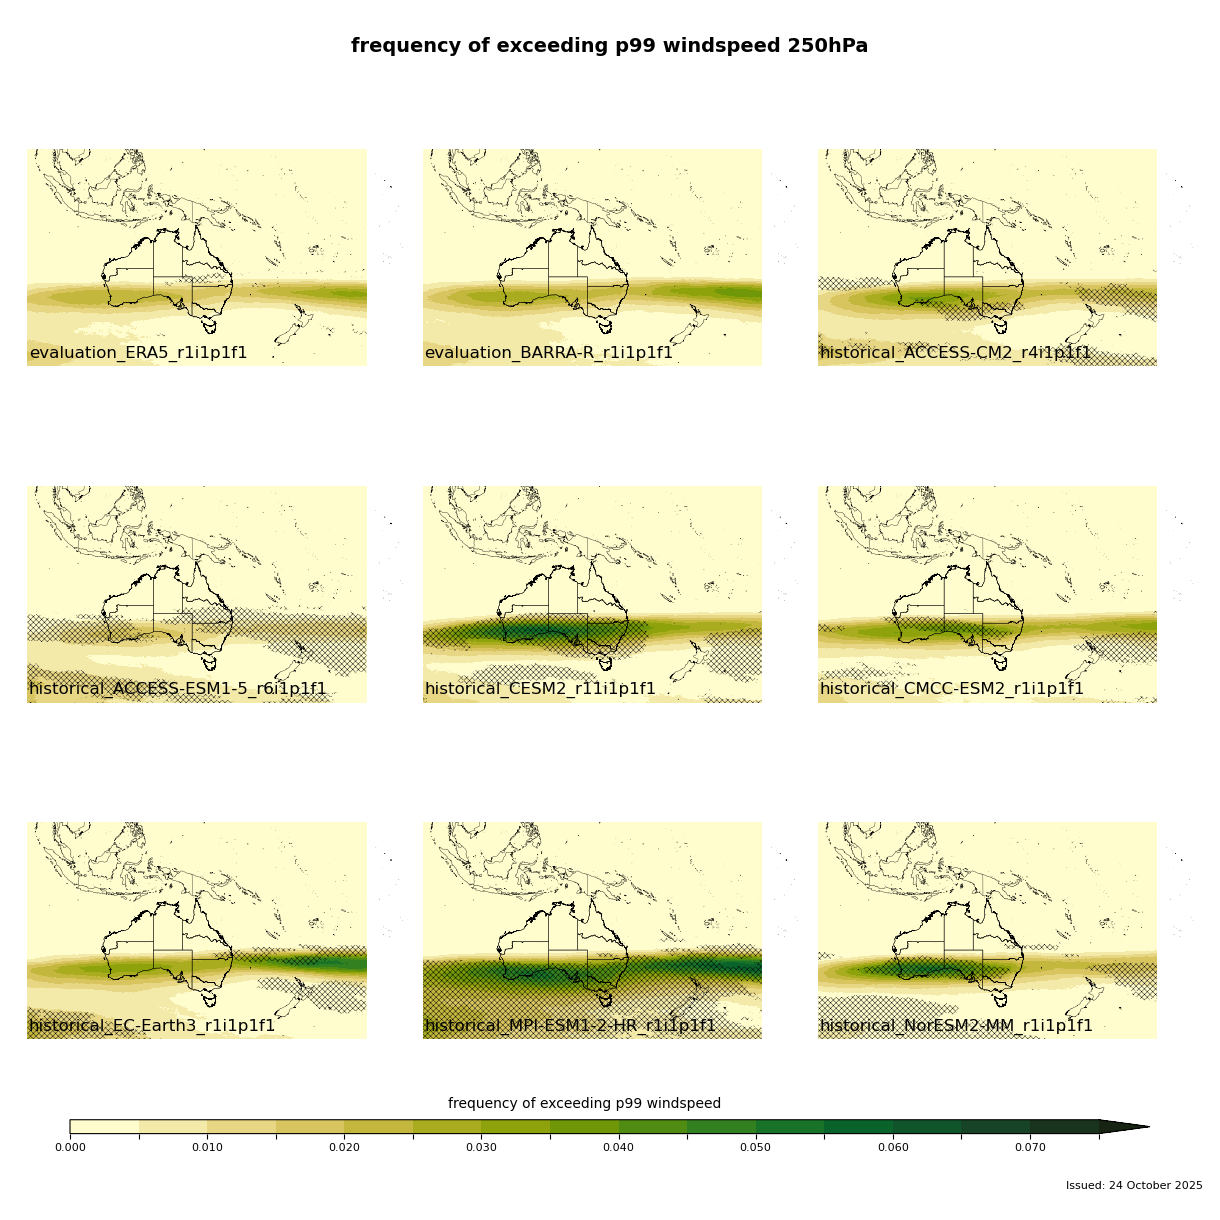

In [24]:
fig, axs = plot_acs_hazard_multi(nrows=3, 
                      ncols=3, 
                      ds_list=[ds.sel(run=run[:27])[f"{turbulence_index}"].mean("time")
                               for run in list_evaluation+ list_historical],
                      stippling_list=[pvals.sel(run=run[:27])["pval"] <0.01
                                      for run in list_evaluation+ list_historical],
                      mask_not_australia=False,
                      ticks=np.arange(0, 0.08, 0.005),
                      tick_interval=2,
                      cbar_extend="max",
                      cbar_label=f"frequency of exceeding p99 {turbulence_index}",
                      figsize=(12,12),
                      title=f"frequency of exceeding p99 {turbulence_index} 250hPa",
                      subplot_titles=[run for run in list_evaluation+ list_historical],
                      xlim=(88.04 , 207.9),
                      ylim=(-53.58 , 13.63),
                      coastlines=True,
                      projection=ccrs.PlateCarree(130),
                      cmap=cmap_dict["ipcc_wind_seq"],
                      watermark="",
                      show_copyright=False,
                     );

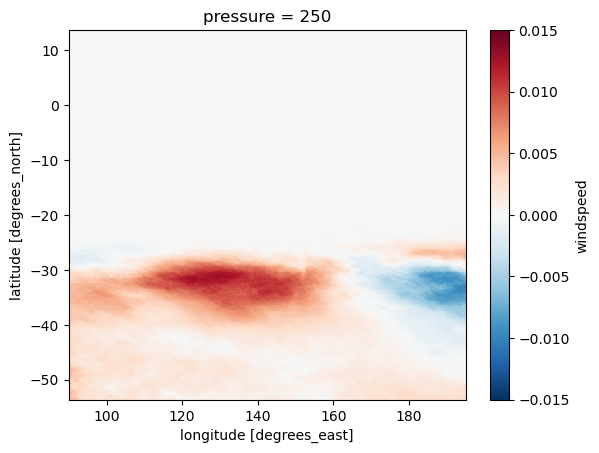

In [56]:
(ds.sel({"run":[run[:27] for run in list_historical]})[turbulence_index].mean(["time"])-baseline).mean("run").plot(vmin=-0.015, vmax=0.015, cmap=cm.RdBu_r)

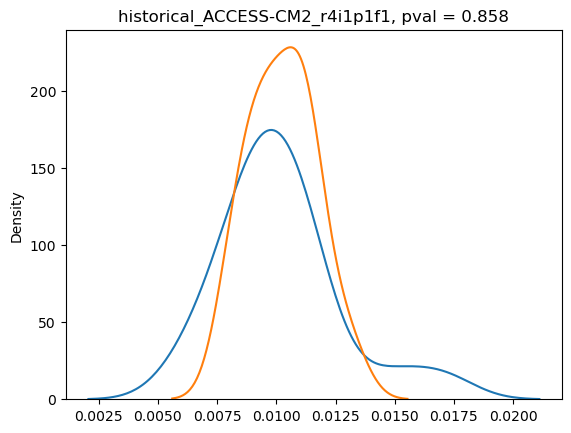

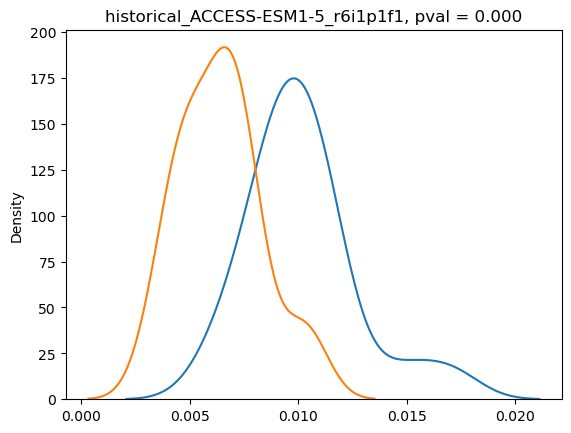

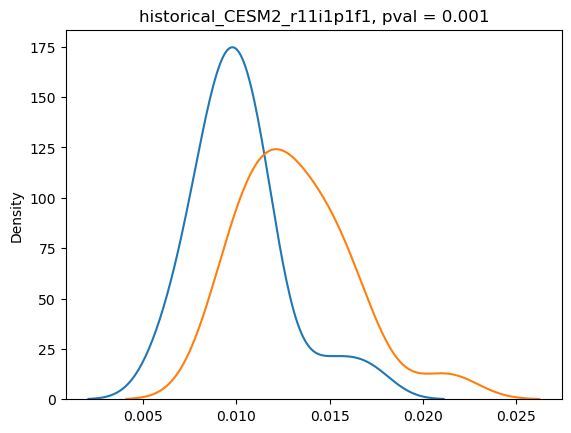

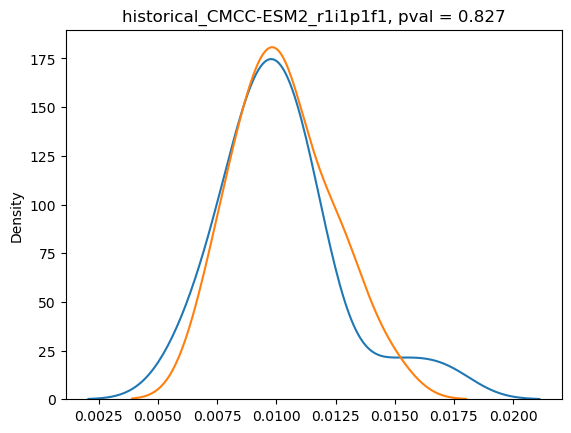

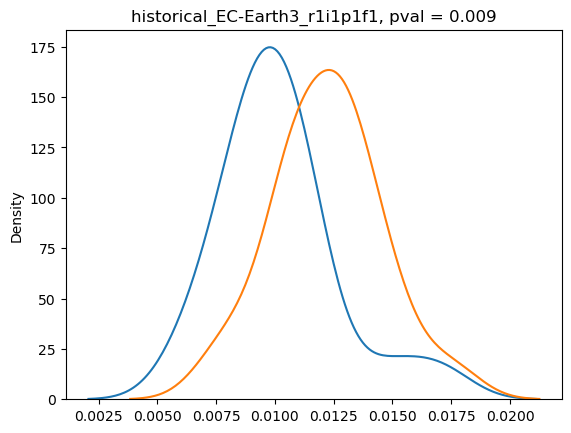

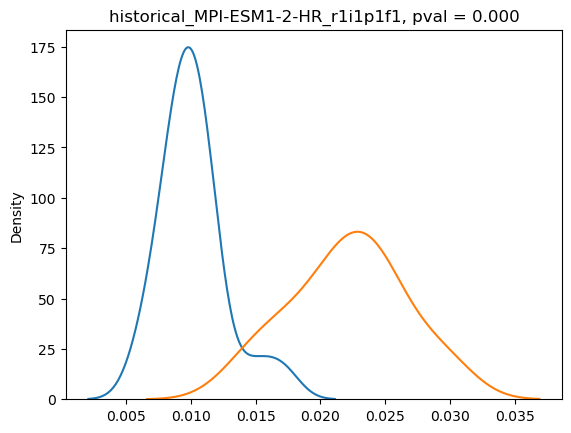

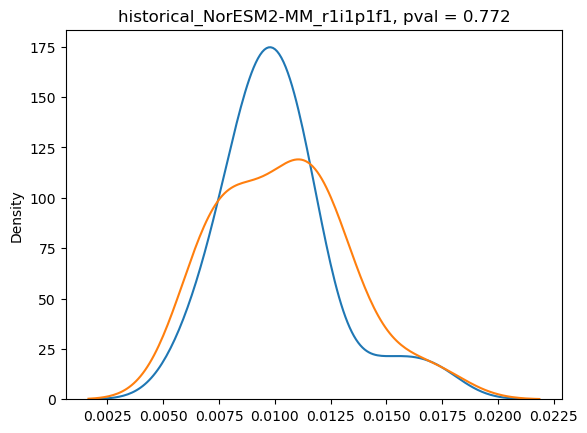

In [36]:
# do this point-wise??
ds_mid_lat_means = ds.sel({"lat":mid_lat_slice, "lon":lon_slice}).mean(["lat", "lon"])[turbulence_index]

ds_eval = ds_mid_lat_means.isel(run=0)
for run in list_historical:
    plt.figure()
    ds_hist = ds_mid_lat_means.sel(run=run[:27])
    sns.kdeplot(ds_eval)
    sns.kdeplot(ds_hist)
    stat, pval = stats.ttest_ind(ds_eval, ds_hist)
    plt.title(f"{run}, pval = {pval:.3f}")

In [ ]:
%%time
turbulence_index = "windspeed"
threshold = p99

delayed_results =[]
for run in list_evaluation + list_historical:
    experiment_id, source_id, member_id = run.split("_")
    print(run)

    def _preprocess(ds, threshold=p99):
        return (ds.chunk({"time":-1,})>threshold).mean(dim=["time"])

    time_range = np.arange(1990, 2009+1)
    filelist = [ f"/scratch/v46/gt3409/TMP_{turbulence_index}/TMP_{turbulence_index}_AUS-15_{source_id}_{experiment_id}_{member_id}_BOM_BARPA-R_v1-r1_6hr_{year}.nc" 
                for year in time_range]
    
    ds = xr.open_mfdataset(filelist, use_cftime=True, preprocess=_preprocess, combine="nested", concat_dim="time").assign_coords({"run":run, "time":time_range})
    delayed_results.append(ds)

results = dask.compute(delayed_results)
results

In [ ]:
hist_eval = xr.concat(results[0], dim=["run"])
hist_eval

In [ ]:
xr.open_dataset("/scratch/v46/gt3409/TEMP_era5_1979-2022.nc")

In [ ]:
hist_eval

In [ ]:
hist_eval.to_netcdf("/scratch/v46/gt3409/historical_evaluation_1990-2009.nc")

In [ ]:
hist_eval = xr.open_dataset("/scratch/v46/gt3409/historical_evaluation_1990-2009.nc")#.sel(lon=slice(88.0355,196.89))
hist_eval

In [ ]:
# hist_eval = xr.open_dataset("/scratch/v46/gt3409/historical_evaluation.nc")

In [ ]:
# hist_eval

In [ ]:
era5 = hist_eval.sel(run='evaluation_ERA5_r1i1p1f1')["windspeed"].mean("time")
barra = hist_eval.sel(run='evaluation_BARRA-R_r1i1p1f1')["windspeed"].mean("time")

In [ ]:
fig, axs = plot_acs_hazard_multi(nrows=3, 
                      ncols=3, 
                      ds_list=[hist_eval.sel(run=run)["windspeed"].mean("time") 
                               for run in list_evaluation+ list_historical],
                      mask_not_australia=False,
                      ticks=np.arange(0, 0.08, 0.005),
                      tick_interval=2,
                      cbar_extend="max",
                      cbar_label="frequency of exceeding p99 windspeed",
                      figsize=(12,12),
                      title="frequency of exceeding p99 windspeed 250hPa",
                      subplot_titles=[run for run in list_evaluation+ list_historical],
                      xlim=(88.04 , 207.9),
                      ylim=(-53.58 , 13.63),
                      coastlines=True,
                      projection=ccrs.PlateCarree(130),
                      cmap=cmap_dict["ipcc_wind_seq"],
                      watermark="",
                      show_copyright=False,
                     );


In [ ]:
plot_acs_hazard_multi(nrows=3, 
                      ncols=3, 
                      ds_list=[(hist_eval.sel(run=run)["windspeed"].mean("time") - barra) 
                               for run in list_evaluation+ list_historical],
                      mask_not_australia=False,
                      ticks=np.arange(-0.05, 0.051, 0.005),
                      tick_interval=2,
                      cbar_extend="both",
                      title="Difference in frequency of exceeding p99 windspeed from BARRA-R",
                      figsize=(12,12),
                      cbar_label="frequency of exceeding p99 windspeed 250hPa",
                      subplot_titles=[run for run in list_evaluation+ list_historical],
                      xlim=(88.04 , 207.9),
                      ylim=(-53.58 , 13.63),
                      coastlines=True,
                      projection=ccrs.PlateCarree(130),
                      # cmap=cmap_dict["ipcc_wind_div"],
                      cmap=cmap_dict["anom"],
                      watermark="",
                      show_copyright=False,
                     );

In [ ]:
plot_acs_hazard_multi(nrows=3, 
                      ncols=3, 
                      ds_list=[(hist_eval.sel(run=run)["windspeed"].mean("time") - era5) 
                               for run in list_evaluation+ list_historical],
                      mask_not_australia=False,
                      ticks=np.arange(-0.05, 0.051, 0.005),
                      tick_interval=2,
                      cbar_extend="both",
                      title="Difference in frequency of exceeding p99 windspeed from ERA5",
                      figsize=(12,12),
                      cbar_label="frequency of exceeding p99 windspeed 250hPa",
                      subplot_titles=[run for run in list_evaluation+ list_historical],
                      xlim=(88.04 , 207.9),
                      ylim=(-53.58 , 13.63),
                      coastlines=True,
                      projection=ccrs.PlateCarree(130),
                      # cmap=cmap_dict["ipcc_wind_div"],
                      cmap=cmap_dict["anom"],
                      watermark="",
                      show_copyright=False,
                     );
                      

In [ ]:
%%time
for run in list_evaluation+ list_historical:
    plt.figure()
    ax = plt.subplot(projection=ccrs.PlateCarree(130))
    hist_eval.sel(run=run)["windspeed"].mean("time").plot(vmax=0.08, transform=ccrs.PlateCarree(), ax=ax)
    plt.title(run)
    ax.yaxis.set_visible(True)
    ax.grid()
    ax.coastlines()


In [ ]:
for run in list_evaluation+list_historical:
    plt.figure()
    ax = plt.subplot(projection=ccrs.PlateCarree(130))
    (hist_eval.sel(run=run)["windspeed"].mean("time") - barra).plot(cmap="RdBu_r", vmin=-0.05, vmax=0.05, transform=ccrs.PlateCarree(), ax=ax)
    plt.title(run)
    ax.yaxis.set_visible(True)
    ax.grid()
    ax.coastlines()

In [ ]:
for run in list_evaluation+list_historical:
    plt.figure()
    ax = plt.subplot(projection=ccrs.PlateCarree(130))
    (hist_eval.sel(run=run)["windspeed"].mean("time") - era5).plot(cmap="RdBu_r", vmin=-0.05, vmax=0.05, transform=ccrs.PlateCarree(), ax=ax)
    plt.title(run)
    ax.yaxis.set_visible(True)
    ax.grid()
    ax.coastlines()

In [ ]:
%%time
turbulence_index = "windspeed"

quantiles_models ={}
for run in list_evaluation + list_historical:
    experiment_id, source_id, member_id = run.split("_")
    print(run)

    for year in np.arange(1990,2009+1):
        # opening
        file = f"/scratch/v46/gt3409/TMP_windspeed/TMP_{turbulence_index}_AUS-15_{source_id}_{experiment_id}_{member_id}_BOM_BARPA-R_v1-r1_6hr_{year}.nc"
        ds_model = xr.open_dataset(file,).assign_coords({"run":run, "year":year})
    
        quantiles_models[f"{run}"] = dask.delayed(ds_model.quantile)(np.arange(0, 1, 0.01),)

results = dask.compute(quantiles_models,)
results

In [ ]:
quantiles_models = xr.concat([results[0][run] for run in list_evaluation + list_historical], 
                             dim="run").assign_coords({"run": list_evaluation + list_historical})
quantiles_models

In [ ]:
%%time
turbulence_index = "windspeed"
fig, axs = plt.subplots(5,2, figsize=(8,12), sharex=True, sharey=True)
i=0
for run in list_evaluation + list_historical:
    print(run)
    # if p-value is less than 0.05 then reject that model
    var = "windspeed"

    plot_model_obs_kde(quantiles_models[var].sel({"run":run}),
                       quantiles_models[var].sel({"run":list_evaluation[1]}),
                       title=f"{run}",
                       xlabel = f"ANN {var}",
                       ax = axs[i//2, i%2])
    plt.xlim(0,100)
    i+=1

In [ ]:
%%time
turbulence_index = "windspeed"
fig, axs = plt.subplots(5,2, figsize=(8,12), sharex=True, sharey=True)
i=0
for run in list_evaluation + list_historical:
    print(run)
    # if p-value is less than 0.05 then reject that model
    var = "windspeed"

    plot_model_obs_kde(quantiles_models[var].sel({"run":run}),
                       quantiles_models[var].sel({"run":list_evaluation[0]}),
                       title=f"{run}",
                       xlabel = f"ANN {var}",
                       ax = axs[i//2, i%2])
    plt.xlim(0,100)
    i+=1

In [ ]:
%%time
turbulence_index = "windspeed"
for run in list_evaluation + list_historical:
    experiment_id, source_id, member_id = run.split("_")
    print(run)

    plt.figure()
    quantiles_models[var].sel({"run":list_evaluation[0]}).plot(color="k",linestyle="--")
    quantiles_models[var].sel({"run":run}).plot(color="r")
    plt.show
    